# Training custom WebSR network weights

This notebook let's you train custom network weights for the `anime4k/cnn-x-s` network. This notebook was modified from these [notebooks](https://github.com/bloc97/Anime4K/tree/master/tensorflow) from Anime4K.

You'll need tensorflow, and this notebook assumes you have some prior knowledge of working with neural networks.

First start with this notebook to train the model. Then use Export_Weights.ipynb notebook to convert trained weights to json.

### Import requirements and make sure Tensorflow is working

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
from PIL import Image
from utils import show_images, preview_dataset

In [3]:
print("TensorFlow version:", tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Detected GPUs:", len(gpus))
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.9.2
Detected GPUs: 1


### Fetch the Data Set

This notebook uses the [SynlaPlus](https://github.com/bloc97/SYNLA-Plus) data set to train. You can set up your own dataset as necessary

In [4]:
import os


def load_dataset(dataset_name):
    
    working_dir = os.getcwd()
    data_dir = os.path.join(working_dir, 'data')
    dataset_dir = os.path.join(data_dir, dataset_name)
    
    
    file_names = os.listdir(dataset_dir)

    tensors = []

    for file_name in file_names:

        path = os.path.join(dataset_dir, file_name)

        raw = tf.io.read_file(path)
        tensor = tf.io.decode_image(raw)
        tensors.append(tensor)

    return tf.data.Dataset.from_tensor_slices(tensors)

In [36]:
images_synla_4096 = load_dataset('Dataset_4096')

In [37]:
images_synla_1024 = load_dataset('Dataset_1024')

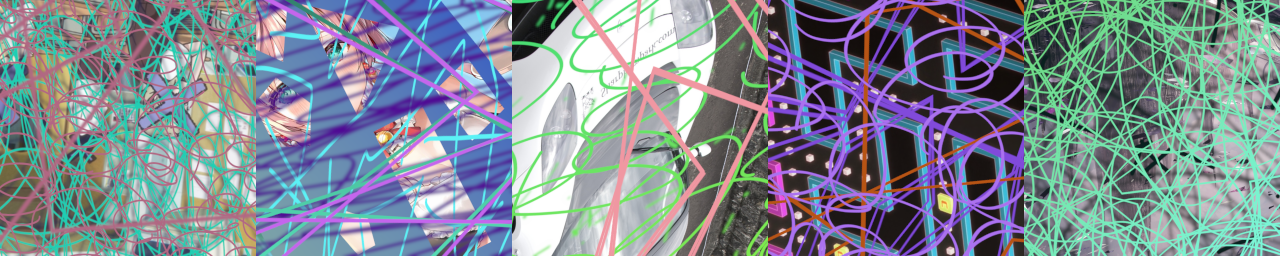

In [38]:
preview_dataset(images_synla_4096)

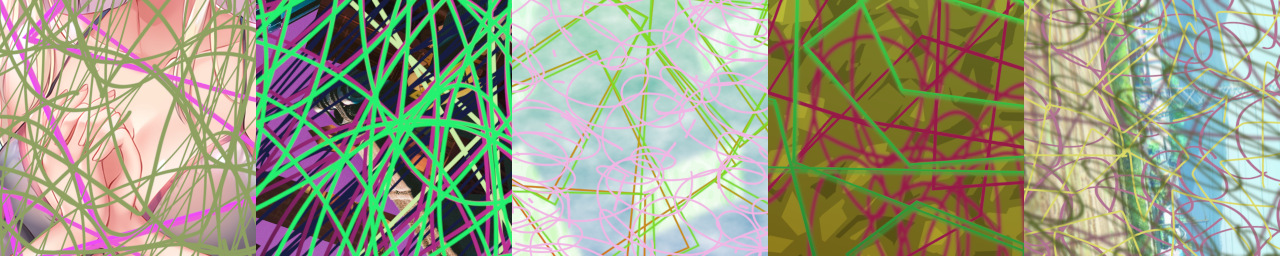

In [39]:
preview_dataset(images_synla_1024)

### The actual SR model

If you change the network, you may end up breaking the weights generation script

In [5]:
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K

#Modified depth_to_space shuffle order for easier shader generation
class DepthToSpace2(tf.keras.layers.Layer):
    def __init__(self, input_depth, **kwargs):
        super(DepthToSpace2, self).__init__(**kwargs)
        self.input_depth = input_depth

    def build(self, input_shape):
        super(DepthToSpace2, self).build(input_shape)

    def call(self, x):
        
        x = tf.split(x, (self.input_depth // 4), axis=-1)
        return tf.concat([tf.nn.depth_to_space(xx, 2) for xx in x], axis=-1)


#SR model that doubles image size
def SR2Model( input_depth=3, highway_depth=4, block_depth=4, init='he_normal', init_last = RandomNormal(mean=0.0, stddev=0.001)):

    input_shape = [None, None, input_depth]
    input_lr = tf.keras.layers.Input(shape=input_shape)
    input_lr2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(input_lr)
    

    x = input_lr
    for i in range(block_depth):
        x = tf.keras.layers.Conv2D(highway_depth, (3, 3), padding='same', kernel_initializer=init)(x)
        x = tf.nn.crelu(x)
    
    x = tf.keras.layers.Conv2D(highway_depth, (3, 3), padding='same', name="conv2d_last",  kernel_initializer=init)(x)
    
    

    x = DepthToSpace2(4)(x)

    

    x = tf.keras.layers.Add()([x, input_lr2])

    model = tf.keras.models.Model(input_lr, x)

    return model

In [6]:
K.reset_uids()
model = SR2Model(input_depth=3, highway_depth=4, block_depth=3)
model.summary(line_length=150)

Model: "model"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, None, None, 3)]          0                 []                                                
                                                                                                                                                      
 conv2d (Conv2D)                                 (None, None, None, 4)            112               ['input_1[0][0]']                                 
                                                                                                                                                      
 tf.compat.v1.nn.crelu (TFOpLambda)              (None, None, None, 8)         

### Data loaders

Data loaders for loading images, augmenting them and preparing them for training

In [48]:
from utils import degrade_ring, degrade_blur_gaussian, degrade_noise_gaussian, degrade_rgb_to_yuv, degrade_yuv_to_rgb

In [49]:
def augment_images(img):
    img = img / 255

    img = tf.image.random_hue(img, 0.5)
    img = tf.image.random_contrast(img, 0.5, 2.0)
    img = tf.clip_by_value(img, 0, 1)
    
    img = tf.image.random_flip_left_right(img)
    img = tf.image.rot90(img, k=tf.experimental.numpy.random.randint(4, dtype=tf.int32))

    if tf.random.uniform(shape=()) < 0.1:
        img = degrade_blur_gaussian(img, 1.0, shape=(5, 5))

    lr, hr = img, img

    if tf.random.uniform(shape=()) < 0.1:
        random_sigma = tf.random.uniform(shape=(), minval=2.0, maxval=5.0)
        lr = degrade_ring(lr, random_sigma, shape=(5, 5))

    if tf.random.uniform(shape=()) < 0.1:
        random_sigma = tf.random.uniform(shape=(), minval=0.1, maxval=0.5)
        lr = degrade_blur_gaussian(lr, random_sigma, shape=(3, 3))

    hr_shape = tf.shape(hr)
    if tf.random.uniform(shape=()) < 0.5:
        lr = tf.image.resize(lr, [hr_shape[-3]//2, hr_shape[-2]//2], method="area")
    else:
        lr = tf.image.resize(lr, [hr_shape[-3]//2, hr_shape[-2]//2], method="bicubic")

    if tf.random.uniform(shape=()) < 0.8:
        lr = degrade_rgb_to_yuv(lr, jpeg_factor=tf.experimental.numpy.random.randint(70, 90, dtype=tf.int32), chroma_subsampling=True, chroma_method="area")
        lr = degrade_yuv_to_rgb(lr, chroma_method="bicubic")
        #Process hr alongside with lr to prevent mean shift from jpeg and conversion errors
        hr = degrade_rgb_to_yuv(hr, jpeg_factor=95, chroma_subsampling=False)
        hr = degrade_yuv_to_rgb(hr)

    return lr, hr

def augment_images_valid(img):
    img = img / 255

    lr, hr = img, img
    
    hr_shape = tf.shape(hr)
    lr = tf.image.resize(lr, [hr_shape[-3]//2, hr_shape[-2]//2], method="area")

    return lr, hr

In [50]:
batch_size = 32

dataset_train = images_synla_4096
dataset_train = dataset_train.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(tf.data.AUTOTUNE)

dataset_valid = images_synla_1024
dataset_valid = dataset_valid.map(augment_images_valid, num_parallel_calls=tf.data.AUTOTUNE)
dataset_valid = dataset_valid.batch(batch_size)
dataset_valid = dataset_valid.prefetch(tf.data.AUTOTUNE)

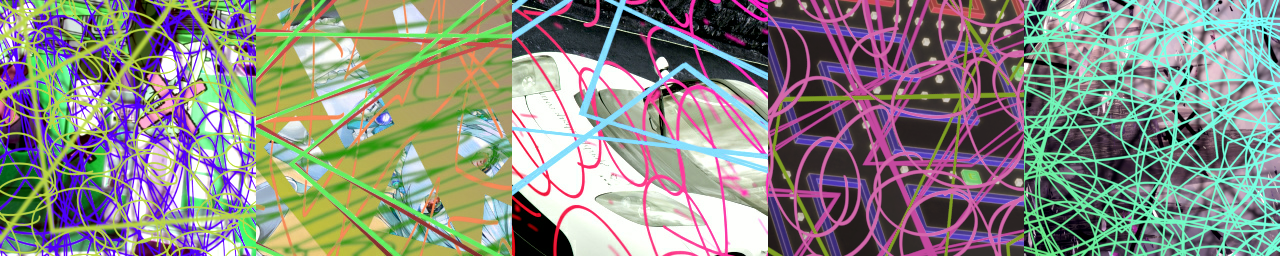

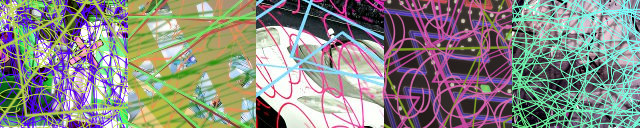

In [51]:
d_pred = next(iter(dataset_train))
show_images(d_pred[1], val_range=[0, 1], scale=4)
show_images(d_pred[0], val_range=[0, 1], scale=8)

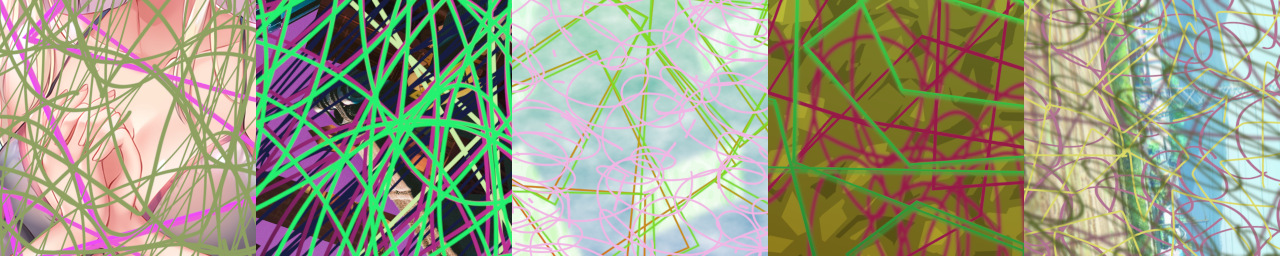

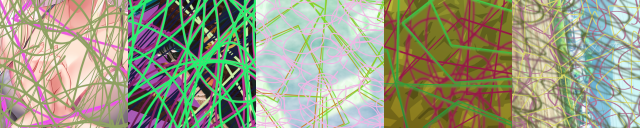

In [52]:
d_pred = next(iter(dataset_valid))
show_images(d_pred[1], val_range=[0, 1], scale=4)
show_images(d_pred[0], val_range=[0, 1], scale=8)

### The loss function

Mean Squared Error focusing on Y channel errors

In [53]:
MSE_Loss = tf.keras.losses.MeanSquaredError()

#YUV loss to weigh in favour of luminance (2 to 1), as humans are less sensitive to chroma degradation
def YUV_Error(y_true, y_pred):
    true_yuv = tf.image.rgb_to_yuv(y_true)
    pred_yuv = tf.image.rgb_to_yuv(y_pred)
    
    true_y, true_u, true_v = tf.split(true_yuv, 3, axis=-1)
    pred_y, pred_u, pred_v = tf.split(pred_yuv, 3, axis=-1)
        
    y_err = MSE_Loss(true_y, pred_y) * 0.5
    u_err = MSE_Loss(true_u, pred_u) * 0.25
    v_err = MSE_Loss(true_v, pred_v) * 0.25
    
    return (y_err + u_err + v_err)

### Actual training script

This can take 5-20 minutes, depending on the speed of your GPU

In [54]:
#Super-convergence with clipping followed by fine tuning with Adam allows somewhat fair convergence within a few minutes
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=10000.0, clipvalue=0.00000001, momentum=0.9, decay=0.0, nesterov=True), loss=YUV_Error)
model.fit(dataset_train.repeat(), epochs=1, steps_per_epoch=4096, validation_data=dataset_valid)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=YUV_Error)
model.fit(dataset_train.repeat(), epochs=1, steps_per_epoch=4096*2, validation_data=dataset_valid)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=YUV_Error)
model.fit(dataset_train.repeat(), epochs=1, steps_per_epoch=4096*2, validation_data=dataset_valid)

8192/8192 [==============================] - 1029s 125ms/step - loss: 0.0032 - val_loss: 0.0013


### Preview Output

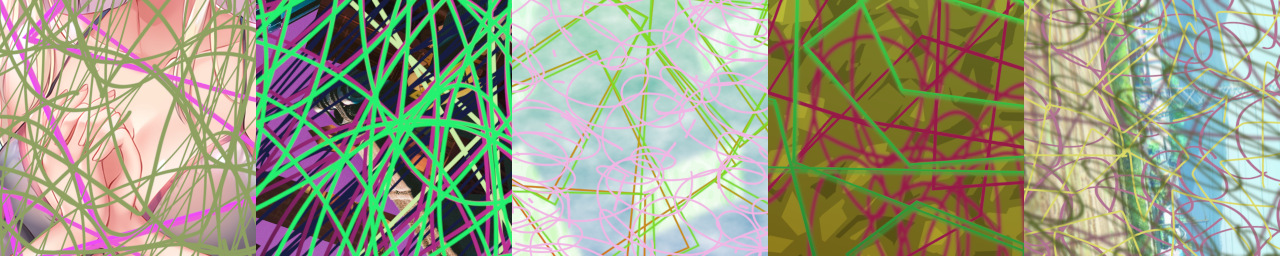

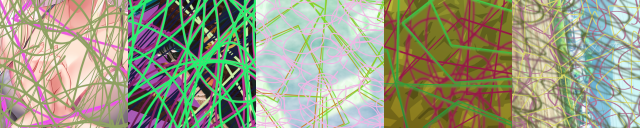

1/1 [==============================] - 0s 35ms/step


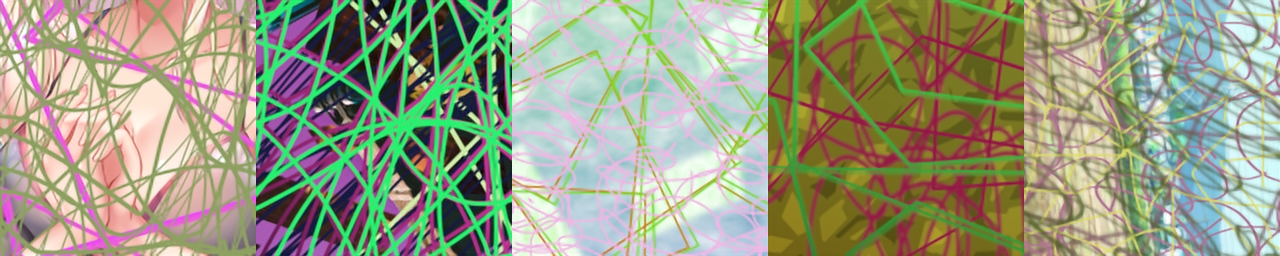

In [57]:
#Show results
d_pred = next(iter(dataset_valid))
show_images(d_pred[1], val_range=[0, 1], scale=8)
show_images(d_pred[0], val_range=[0, 1], scale=8)

pred_pred = model.predict(d_pred[0])
d_pred0 =  tf.image.resize(d_pred[0], [d_pred[1].shape[1], d_pred[1].shape[2]], method="bilinear")
show_images(pred_pred, val_range=[0, 1], scale=4)
#show_images(pred_pred - d_pred0, val_range=[-0.2, 0.2], scale=4)
#show_images(d_pred[1] - d_pred0, val_range=[-0.2, 0.2], scale=4)

Save the model, then go to Export_Weights.ipynb

In [18]:
model.save_weights("model-checkpoint.h5")